### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 5
### Due: Friday, Mar 7nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

#### Part 1

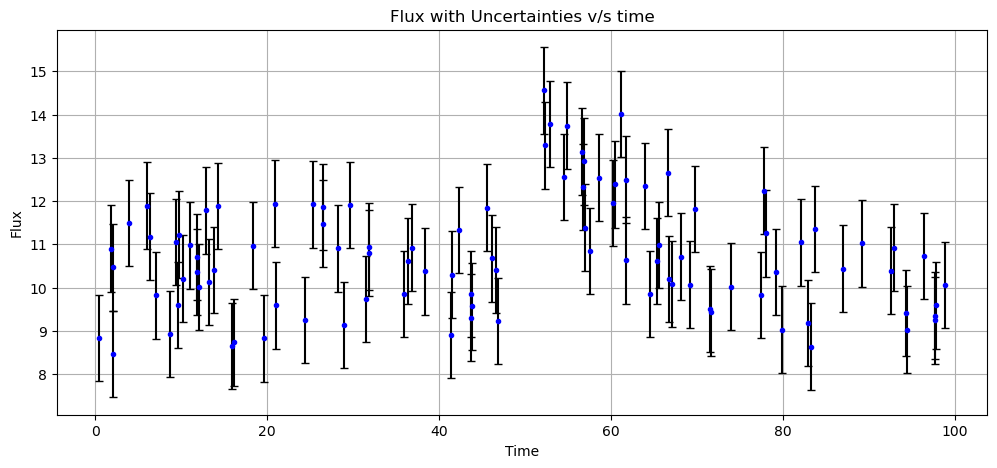

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data_dir = '../../../homeworks/hw_data/'

data = np.load(data_dir+'hw5_data_1.npy')

time, flux, flux_uncert = data[:,0], data[:,1], data[:,2]

plt.figure(figsize=(12,5))
plt.errorbar(time, flux, yerr=flux_uncert, fmt='.b', ecolor='k', capsize=3)
plt.grid(True)
plt.ylabel("Flux")
plt.xlabel("Time")
plt.title("Flux with Uncertainties v/s time")
plt.show()

#### Part 2

In [2]:
import scipy

# burst model
def burst_model(mod_params, t):#(b, A, alpha, t, t0):

    b, A, t0, alpha = mod_params
    
    y = np.ones(t.shape[0])*b
    y[t>=t0] = b + A*np.exp(-alpha*(t[t>=t0]-t0))

    return y


# compute the data likelihood given a model
def lnLikelihood(mod_params, model=burst_model):

    y_fit = burst_model(mod_params, time)
    return np.sum(scipy.stats.norm.logpdf(flux, y_fit, flux_uncert))


#### Part 3

In [3]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from scipy.stats import uniform

# uniform prior in b, A, t0 and alpha
def lnPrior(mod_params):
    
    b, A, t0, alpha = mod_params
    
    b_prior = uniform.logpdf(b, loc=0, scale=50) #logpdf(b, loc=0, scale=50)
    A_prior = uniform.logpdf(A, loc=0, scale=50) #logpdf(A, loc=0, scale=50)
    t0_prior = uniform.logpdf(t0, loc=0, scale=100) #logpdf(t0, loc=0, scale=100)
    alpha_prior = uniform.logpdf(alpha, loc=-5, scale=10) #logpdf(alpha, loc=-5, scale=10) # is along [loc, loc+scale]
    
    return (b_prior+A_prior+t0_prior+alpha_prior)


# dimension of parameter space
ndim = 4

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, lnLikelihood, lnPrior, cov, 
                 outDir='./ptmcmc_HW3', resume=False)

Optional mpi4py package is not installed.  MPI support is not available.


In [5]:
# sampler for N steps
N = int(5e6)
x0 = np.array([25.0, 25.0, 50.0, 0.0]) #np.array([15.2, 35.5, 20.0, 0.1])

#sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50) #with log pdf no warnings

Finished 0.20 percent in 6.564706 s Acceptance rate = 0.442411Adding DE jump with weight 50
Finished 100.00 percent in 3426.679540 s Acceptance rate = 0.235574
Run Complete


#### Part 4

In [6]:
# Load in the chain
chain = np.loadtxt('./ptmcmc_HW3/chain_1.txt')

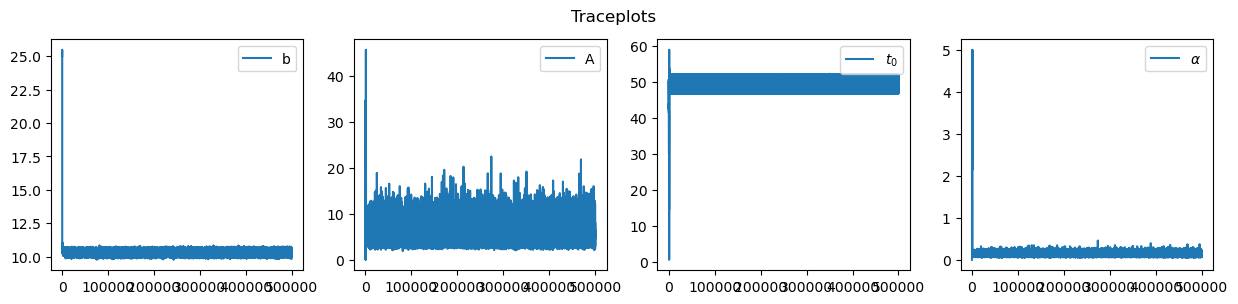

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,3))


ax[0].plot(chain[:,0], label=r'b')
ax[0].legend()

ax[1].plot(chain[:,1], label=r'A')
ax[1].legend()

ax[2].plot(chain[:,2], label=r'$t_0$')
ax[2].legend()

ax[3].plot(chain[:,3], label=r'$\alpha$')
ax[3].legend()

plt.suptitle('Traceplots')

plt.show()

Autocorrelation length for b:  47
Autocorrelation length for A:  20
Autocorrelation length for t0:  172
Autocorrelation length for alpha:  970
  


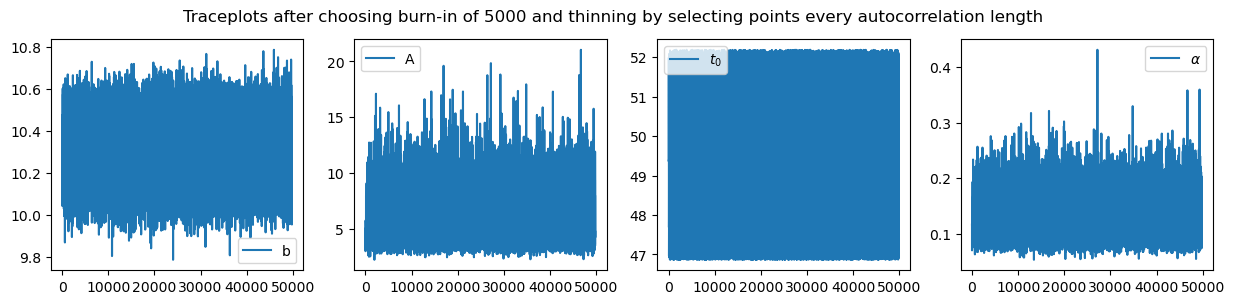

In [9]:
import acor

## Burn-in
burn_in = 2000

## Calculating the Auto-correlation length for all parameters
b_acl = int(acor.acor(chain[:,0])[0])
A_acl = int(acor.acor(chain[:,1])[0])
t0_acl = int(acor.acor(chain[:,2])[0])
alpha_acl = int(acor.acor(chain[:,3])[0])

## Burned and thinned samples of the prameters. I'm choosing 10 because it is taking a very long time to sample more points.
## with 5e6 it takes an hour to run and my laptop gets very very hot. I was just scared if it could get damaged.
burn_thin_b = chain[burn_in::10,0]
burn_thin_A = chain[burn_in::10,1]
burn_thin_t0 = chain[burn_in::10,2]
burn_thin_alpha = chain[burn_in::10,3]

print("Autocorrelation length for b: ", b_acl)
print("Autocorrelation length for A: ", A_acl)
print("Autocorrelation length for t0: ", t0_acl)
print("Autocorrelation length for alpha: ", alpha_acl)
print("  ")


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,3))

ax[0].plot(burn_thin_b, label=r'b')
ax[0].legend()

ax[1].plot(burn_thin_A, label=r'A')
ax[1].legend()

ax[2].plot(burn_thin_t0, label=r'$t_0$')
ax[2].legend()

ax[3].plot(burn_thin_alpha, label=r'$\alpha$')
ax[3].legend()

plt.suptitle('Traceplots after choosing burn-in of 5000 and thinning by selecting points every autocorrelation length')

plt.show()

#### Part 5

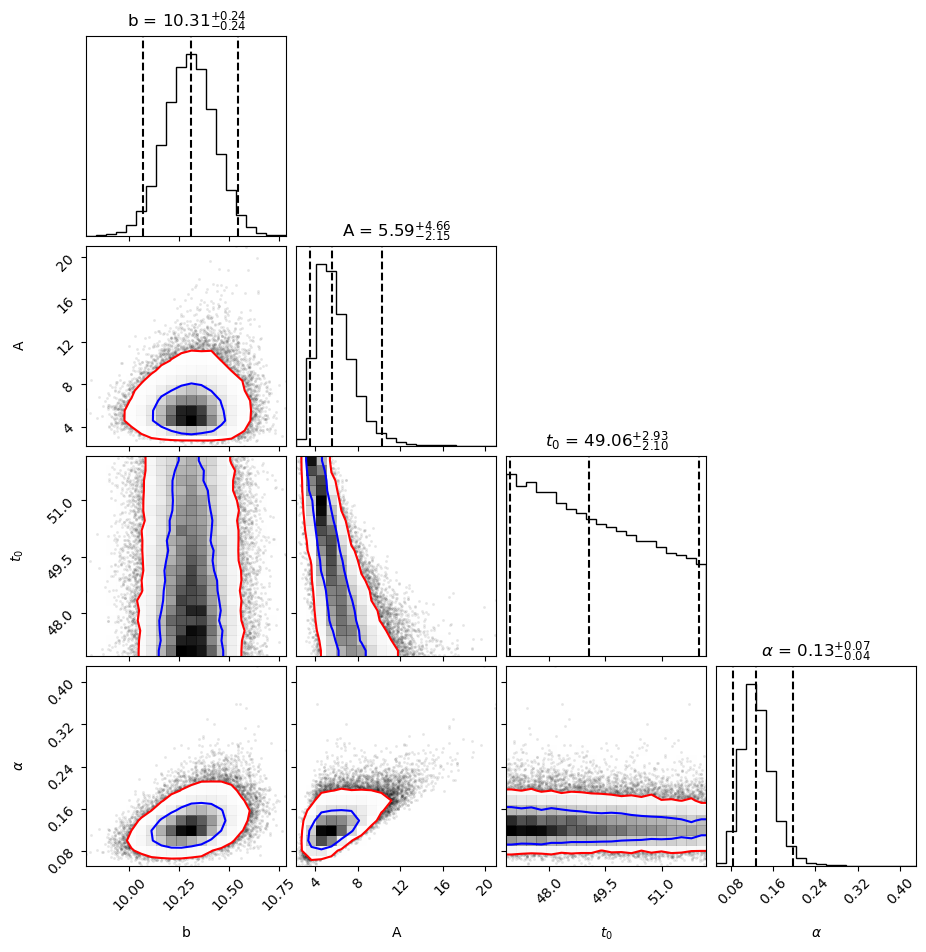

In [13]:
import corner


# Getting the minimum length of the 4 posterior samples because the autocorrelation length are different for different parameters
# and corner_arr below must have equal no. of samples for all parameters
eq_len = min(len(burn_thin_b), len(burn_thin_A), len(burn_thin_t0), len(burn_thin_alpha))
corner_arr = np.array([burn_thin_b[:eq_len], burn_thin_A[:eq_len], burn_thin_t0[:eq_len], burn_thin_alpha[:eq_len]]).T

corner.corner(corner_arr, labels=['b', 'A', r'$t_0$', r'$\alpha$'], show_titles=True, levels=[0.68, 0.95], 
              quantiles=[0.025, 0.5, 0.975], color='k', plot_contours=True,
              contour_kwargs={'colors': ['red', 'blue']})
plt.show()

#### Part 6

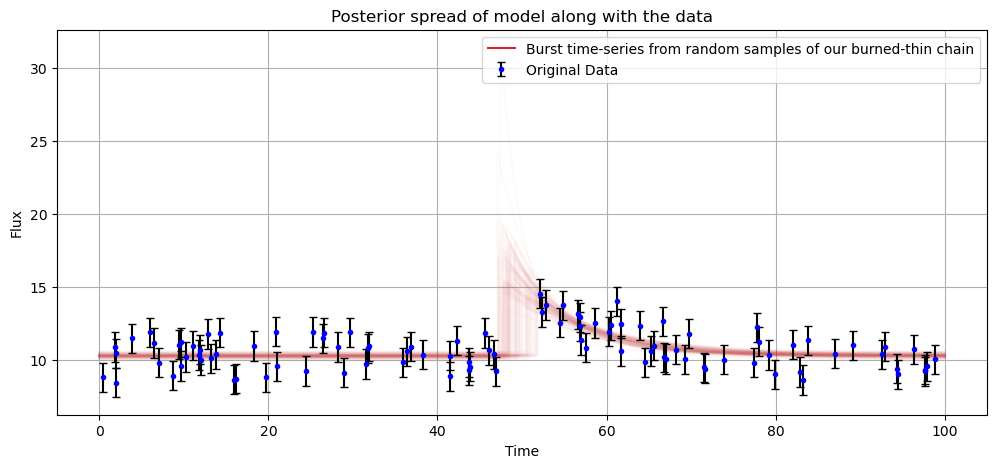

In [14]:
# 100 random sample indices
rand_ind = np.random.choice(eq_len, size=100, replace=False)
tgrid = np.linspace(0, 100, 10000)

plt.figure(figsize=(12,5))
for ind in rand_ind:
    rand_mod_params = [burn_thin_b[ind], burn_thin_A[ind], burn_thin_t0[ind], burn_thin_alpha[ind]]
    plt.plot(tgrid, burst_model(rand_mod_params, tgrid), color='tab:red', alpha=0.02)

plt.plot([], [], color='tab:red', label="Burst time-series from random samples of our burned-thin chain")
plt.errorbar(time, flux, yerr=flux_uncert, fmt='.b', ecolor='k', capsize=3, label='Original Data')
plt.grid(True)
plt.ylabel("Flux")
plt.xlabel("Time")
plt.title("Posterior spread of model along with the data")
plt.legend(loc=1)
plt.show()

#### Part 7

##### Defining the gauss profile functions, the prior transform functions for both burst and gauss models. And also the log likelihood function for gauss model

In [15]:
import ultranest


# Gaussian Profile model
def gauss_profile(mod_params, t):#(b, A, alpha, t, t0):

    b, A, t0, sig_w = mod_params
    
    return b + A*np.exp(-((t-t0)**2)/(2*(sig_w**2)))


# Priors
def my_prior_transform_burst(cube):
    params = cube.copy()

    # transform b parameter: uniform prior
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo

    # transform A parameter: uniform prior
    lo = 0
    hi = 50
    params[1] = cube[1] * (hi - lo) + lo
    
    # transform t0 parameter: uniform prior
    lo = 0
    hi = 100
    params[2] = cube[2] * (hi - lo) + lo
    
    # transform alpha parameter: log-uniform prior
    lo = -5
    hi = 5
    params[3] = 10**(cube[3] * (hi - lo) + lo)

    return params


def my_prior_transform_gauss(cube):
    params = cube.copy()

    # transform b parameter: uniform prior
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo

    # transform A parameter: uniform prior
    lo = 0
    hi = 50
    params[1] = cube[1] * (hi - lo) + lo
    
    # transform t0 parameter: uniform prior
    lo = 0
    hi = 100
    params[2] = cube[2] * (hi - lo) + lo
    
    # transform sig_w parameter: log-uniform prior
    lo = -2
    hi = 2
    params[3] = 10**(cube[3] * (hi - lo) + lo) #10**(cube[3] * (np.log10(hi) - np.log10(lo)) + np.log10(lo))

    return params


# compute the data likelihood given a model
def lnLikelihood_gauss(mod_params):

    y_fit = gauss_profile(mod_params, time)
    return np.sum(scipy.stats.norm.logpdf(flux, y_fit, flux_uncert))
    

##### Defining parameter names for both model and getting ready to sample by creating the sample object.

In [16]:
param_burst = ['b', 'A', 't0', 'alpha']
param_gauss = ['b', 'A', 't0', 'sig_w']

sampler_burst = ultranest.ReactiveNestedSampler(param_burst, lnLikelihood, 
                                          my_prior_transform_burst)

sampler_gauss = ultranest.ReactiveNestedSampler(param_gauss, lnLikelihood_gauss, 
                                          my_prior_transform_gauss)

##### Let's Sample!!!!!

In [17]:
result_burst = sampler_burst.run()
sampler_burst.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .65 [-140.7128..-140.7128]*| it/evals=8040/140891 eff=5.7228% N=400    0 
[ultranest] Likelihood function evaluations: 141042
[ultranest]   logZ = -156.2 +- 0.1559
[ultranest] Effective samples strategy satisfied (ESS = 1936.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.

logZ = -156.235 +- 0.449
  single instance: logZ = -156.235 +- 0.187
  bootstrapped   : logZ = -156.209 +- 0.449
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.80  │ ▁▁▁▁▁▁▁▁▁▂▂▂▃▅▆▆▆▇▇▇▇▇▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁ │10.79     10.30 +- 0.12
    A                   : 1.6   │ ▁▁▃▆▇▇▇▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁   ▁ ▁▁     ▁ │21.8      5.7 +- 1.7
    t0                  : 4

##### Checking if the posteriors here are same as for my bayesian runs.

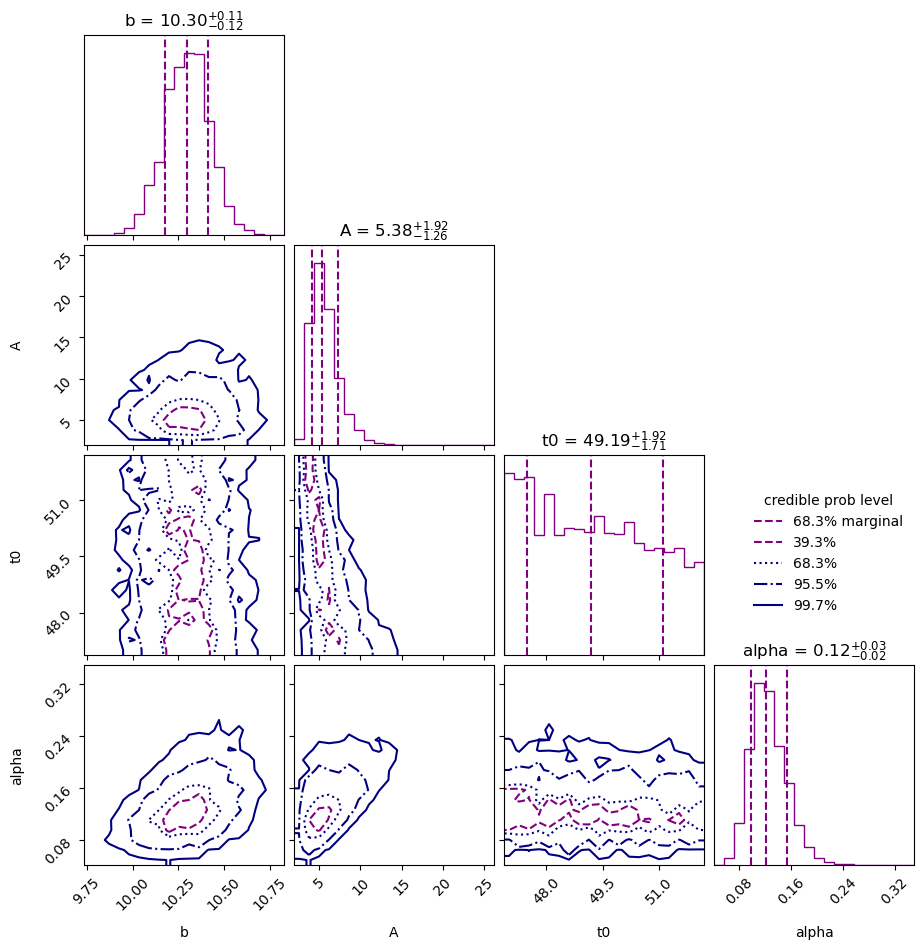

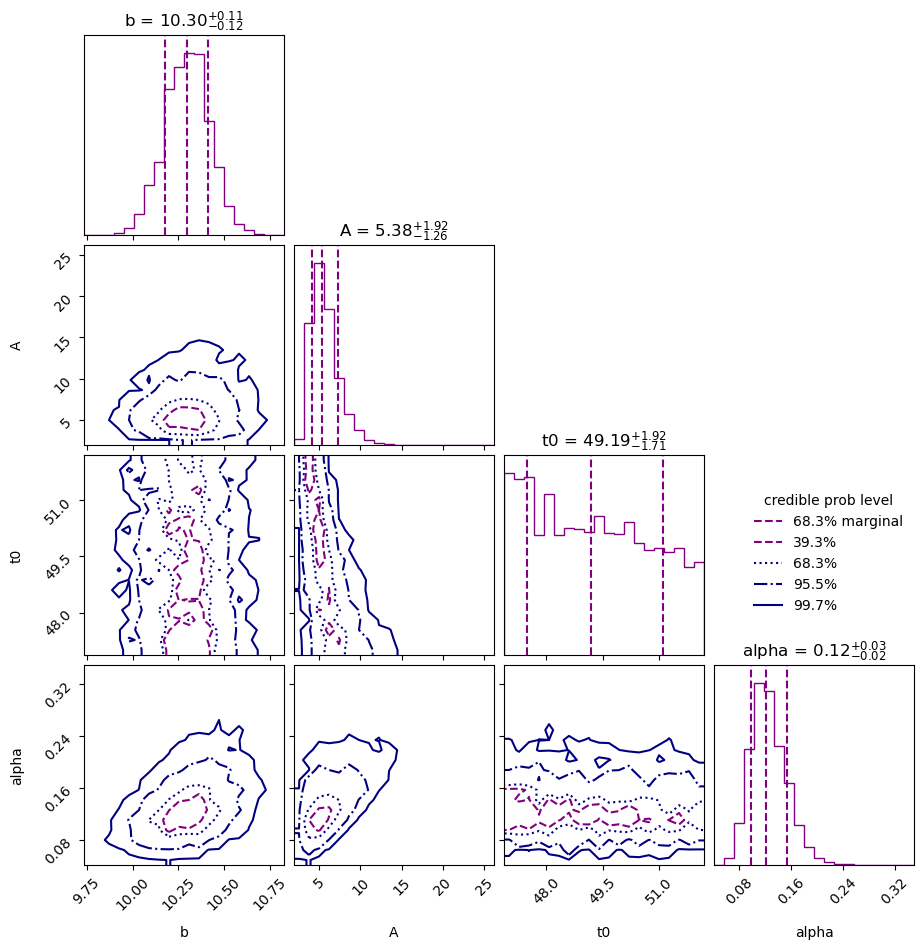

In [18]:
from ultranest.plot import cornerplot

cornerplot(result_burst)

##### The above corner plot matches my ptmcmc posterior samples corner plot

##### Now sample for the gauss model in order to compute the bayes factor

In [19]:
result_gauss = sampler_gauss.run()
sampler_gauss.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .30 [-144.4487..-144.4485]*| it/evals=8280/271033 eff=3.0595% N=400    0 
[ultranest] Likelihood function evaluations: 271064
[ultranest]   logZ = -160.5 +- 0.1584
[ultranest] Effective samples strategy satisfied (ESS = 2224.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.

logZ = -160.532 +- 0.283
  single instance: logZ = -160.532 +- 0.188
  bootstrapped   : logZ = -160.545 +- 0.283
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.83  │ ▁▁▁▁▁▁▁▁▁▂▂▃▄▄▅▆▇▇▇▆▇▅▆▄▄▃▂▁▁▁▁▁▁▁▁▁▁ │10.82     10.32 +- 0.12
    A                   : 1.36  │ ▁▁▁▁▁▁▂▂▃▄▆▆▆▇▇▇▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁   ▁ │5.01      2.76 +- 0.39
    t0                  :

##### Although I specified a correct sig_w prior range in my prior transform function, I see that the posterior for it is ranging out of the specified prior range. It starts with the -2, 2 range but afterwards jumps out. Not sure why.

##### Computing bayes factor from the ultranest documentation: https://johannesbuchner.github.io/UltraNest/example-sine-modelcomparison.html

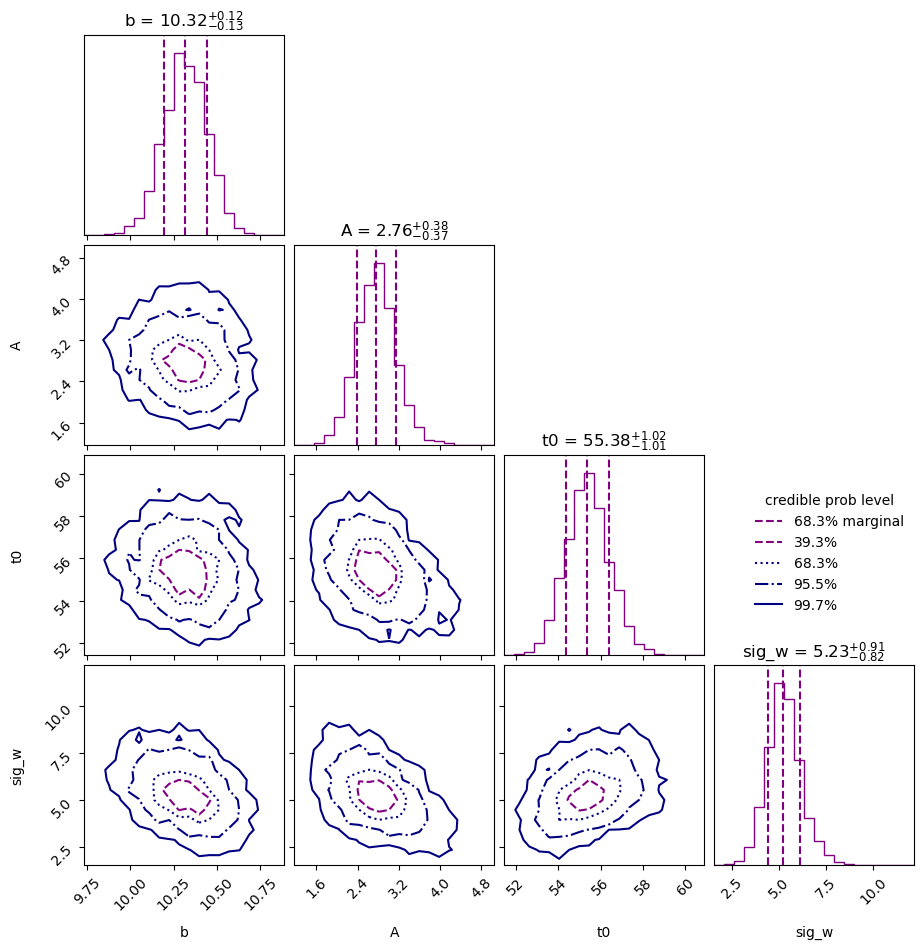

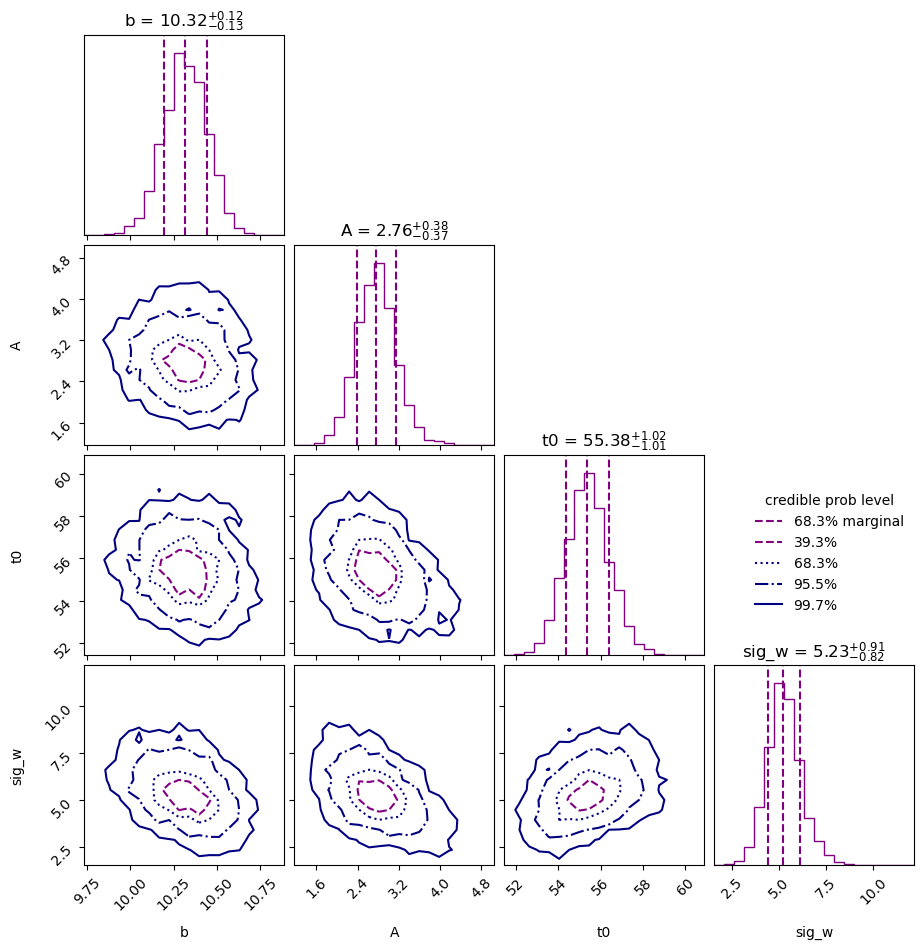

In [21]:
cornerplot(result_gauss)

In [22]:
BF = np.exp(result_burst['logz'] - result_gauss['logz'])
print("Bayes Factor = %.2f" % BF)
print("This shows that the Burst model is a strongly favored description of the data.")

Bayes Factor = 73.53
This shows that the Burst model is a strongly favored description of the data.


<span style="color:green"> NP: Correct! Good job! </span>